### stacked map of single galaxies from pair catalog

In [6]:
import numpy as np
import pandas as pd
import healpy as hp
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18 as cosmo
from astropy.io import fits
from scipy.ndimage import gaussian_filter
from tqdm.notebook import tqdm
from helper import symmetrize_map
from helper import radial_profile

In [7]:
# --- Settings and constants ---
h = cosmo.h
nside = 2048
fwhm_rad = np.radians(8 / 60)
box_size_hmpc = 100.0 # Mpc/h
grid_size = 100
cell_size_hmpc = box_size_hmpc / grid_size
half_box_hmpc = box_size_hmpc / 2
extent = [-half_box_hmpc, half_box_hmpc, -half_box_hmpc, half_box_hmpc]

offsets = np.linspace(-half_box_hmpc + cell_size_hmpc/2,
                      half_box_hmpc - cell_size_hmpc/2, grid_size)
off_x, off_y = np.meshgrid(offsets, offsets)
off_x, off_y = off_x.ravel(), off_y.ravel()

# --- Load κ map and mask ---
alm_file = "data/COM_Lensing_4096_R3.00/MV/dat_klm.fits"
mask_file = "data/COM_Lensing_4096_R3.00/mask.fits"

alm_data = fits.open(alm_file)[1].data
alm = alm_data['REAL'] + 1j * alm_data['IMAG']
lmax = hp.Alm.getlmax(len(alm))
kmap = hp.alm2map(hp.smoothalm(alm, fwhm=fwhm_rad), nside=nside, lmax=lmax)
mask = hp.read_map(mask_file)

# --- Load pairs catalog ---
pairs = pd.read_csv('data/paircatalogs/galaxy_pairs_catalog_20hmpc.csv')

# Extract singular galaxies (concatenate both sides of pairs)
l_all = np.concatenate([pairs['l1'], pairs['l2']]) # degrees
b_all = np.concatenate([pairs['b1'], pairs['b2']]) # degrees
z_all = np.concatenate([pairs['z1'], pairs['z2']])
D_all = cosmo.comoving_distance(z_all).value * h # Mpc/h

ids_all = np.concatenate([pairs['LRG_ID1'], pairs['LRG_ID2']])
ids_all = np.unique(ids_all)
weights = np.ones(len(l_all))  # equal weights
weights = np.concatenate([pairs['w1'], pairs['w2']])

# --- Stack kappa ---
def stack_kappa(l_arr, b_arr, D_arr, weights):
    sz = grid_size**2
    sum_wk = np.zeros(sz)
    sum_w = np.zeros(sz)

    for i in tqdm(range(len(l_arr)), desc="Stacking galaxies"):
        l = l_arr[i]
        b = b_arr[i]
        D = D_arr[i]

        cosb = np.cos(np.radians(b))
        dl = (off_x / D) * (180 / np.pi) / np.clip(cosb, 1e-6, None)
        db = (off_y / D) * (180 / np.pi)

        l_grid = l + dl
        b_grid = b + db

        theta = np.radians(90 - b_grid)
        phi = np.radians(l_grid)
        pix = hp.ang2pix(nside, theta, phi)

        w = weights[i] * mask[pix]
        if np.sum(w) == 0:
            continue

        κ_vals = kmap[pix]
        sum_wk += w * κ_vals
        sum_w += w

    κ_mean = np.zeros_like(sum_w)
    valid = sum_w > 0
    κ_mean[valid] = sum_wk[valid] / sum_w[valid]
    return κ_mean.reshape(grid_size, grid_size)

Stacking galaxies:   0%|          | 0/145080 [00:00<?, ?it/s]

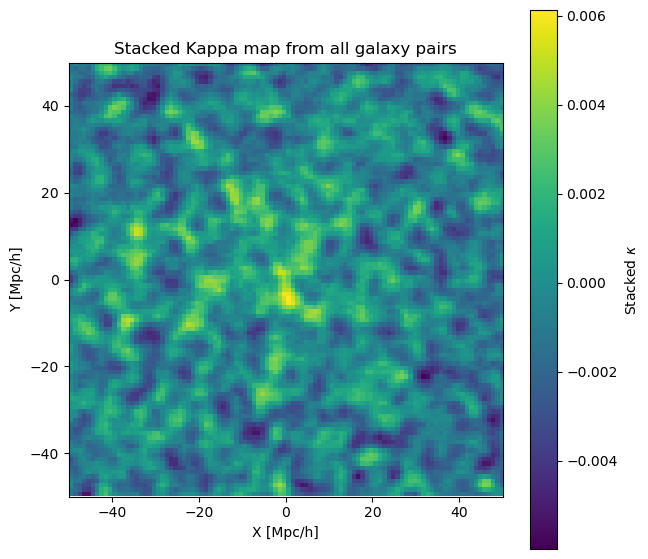

In [8]:
# --- Run stacking ---
kappa_stack = stack_kappa(l_all, b_all, D_all, weights)
# Plot stacked map
plt.figure(figsize=(7, 7))
im = plt.imshow(kappa_stack, origin='lower', extent=extent, cmap='viridis')
plt.colorbar(im, label=r'Stacked $\kappa$')
plt.xlabel('X [Mpc/h]')
plt.ylabel('Y [Mpc/h]')
plt.title('Stacked Kappa map from all galaxy pairs')
plt.show()

/Users/carolinewu/PycharmProjects/astrophysics/helper.py:99: RuntimeWarning: invalid value encountered in divide
  kappa_avg = np.bincount(r_flat, weights=kappa_flat) / np.bincount(r_flat)


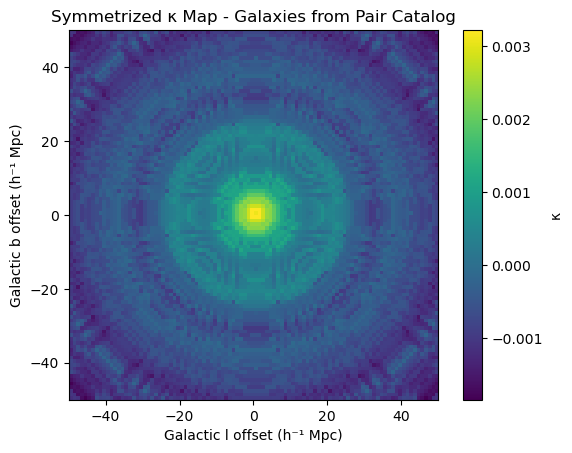

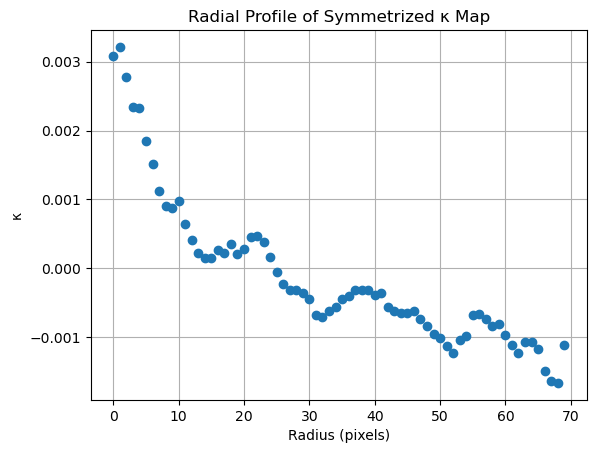

(array([ 3.08113996e-03,  3.21584501e-03,  2.77567733e-03,  2.34743704e-03,
         2.32976752e-03,  1.84682103e-03,  1.51887311e-03,  1.12030937e-03,
         9.07662684e-04,  8.68091738e-04,  9.70712621e-04,  6.41084584e-04,
         4.13857009e-04,  2.16889165e-04,  1.44388816e-04,  1.40841241e-04,
         2.66261296e-04,  2.20593502e-04,  3.44800353e-04,  2.10574226e-04,
         2.82358084e-04,  4.53051142e-04,  4.67757250e-04,  3.80038180e-04,
         1.57423029e-04, -6.38072246e-05, -2.28763680e-04, -3.18340220e-04,
        -3.24287155e-04, -3.62119135e-04, -4.44295392e-04, -6.88933458e-04,
        -7.09915339e-04, -6.30231510e-04, -5.59839825e-04, -4.53791779e-04,
        -4.11928959e-04, -3.20561903e-04, -3.20536759e-04, -3.23860231e-04,
        -3.86075588e-04, -3.66136894e-04, -5.72675801e-04, -6.29342312e-04,
        -6.55510731e-04, -6.49290341e-04, -6.24337126e-04, -7.33350429e-04,
        -8.40073098e-04, -9.52909035e-04, -1.02237066e-03, -1.13004771e-03,
        -1.2

In [9]:
# kappa_smooth = gaussian_filter(kappa_stack, sigma=2)  # 8' smoothing

# --- Plot symmetrized map ---
kappa_sym = symmetrize_map(kappa_stack)

plt.imshow(kappa_sym, origin='lower', extent=extent, cmap='viridis')
plt.colorbar(label='κ')
plt.xlabel("Galactic l offset (h⁻¹ Mpc)")
plt.ylabel("Galactic b offset (h⁻¹ Mpc)")
plt.title("Symmetrized κ Map - Galaxies from Pair Catalog")
plt.show()

# --- Plot radial profile ---
radial_profile(kappa_sym, title="Radial Profile of Symmetrized κ Map", zoom=70)

Stacking galaxies:   0%|          | 0/70783 [00:00<?, ?it/s]

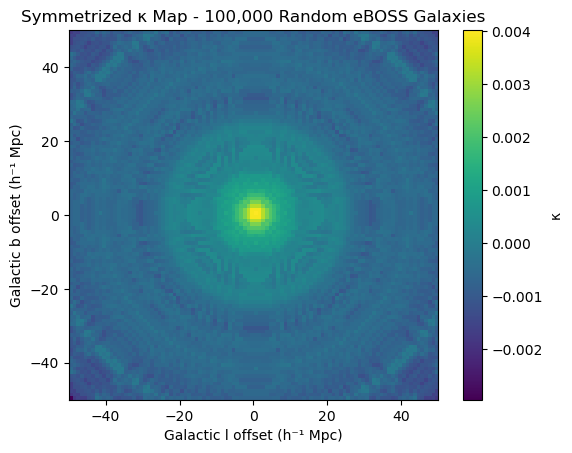

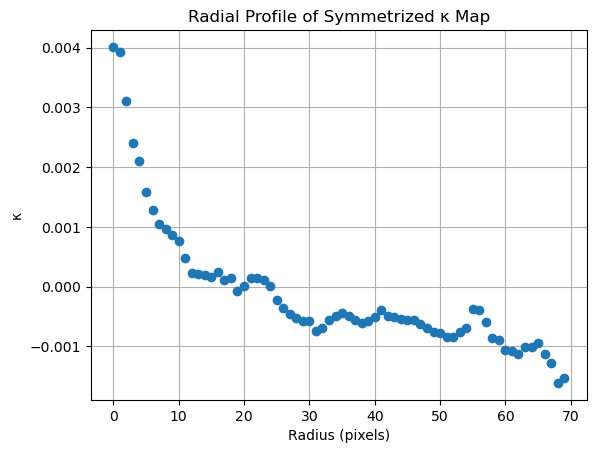

(array([ 4.01301114e-03,  3.92763833e-03,  3.10261362e-03,  2.40165084e-03,
         2.10390041e-03,  1.57877851e-03,  1.29178011e-03,  1.04739483e-03,
         9.64676886e-04,  8.59911178e-04,  7.64164237e-04,  4.78631092e-04,
         2.26635805e-04,  2.10829122e-04,  1.90324324e-04,  1.55940957e-04,
         2.41878824e-04,  1.14243909e-04,  1.37453557e-04, -6.97802846e-05,
         7.36692904e-06,  1.41108123e-04,  1.37636834e-04,  1.19299540e-04,
         1.32483442e-05, -2.27229646e-04, -3.54188096e-04, -4.58260339e-04,
        -5.25040900e-04, -5.74713684e-04, -5.76301770e-04, -7.40038517e-04,
        -6.89275340e-04, -5.58085828e-04, -4.88974780e-04, -4.42231490e-04,
        -4.91864112e-04, -5.61212289e-04, -6.04441750e-04, -5.69782267e-04,
        -4.99436206e-04, -3.93173937e-04, -4.94159518e-04, -5.10899830e-04,
        -5.40016438e-04, -5.64131324e-04, -5.60923127e-04, -6.24161658e-04,
        -6.94613165e-04, -7.53687725e-04, -7.76317853e-04, -8.48742758e-04,
        -8.3

In [10]:
# import numpy as np
# import healpy as hp
# import matplotlib.pyplot as plt
# from astropy.cosmology import Planck18 as cosmo
# from astropy.io import fits
# from scipy.ndimage import gaussian_filter

# --- Settings and constants ---
h = cosmo.h
nside = 2048
fwhm_rad = np.radians(8 / 60)
box_size_hmpc = 100.0 # Mpc/h
grid_size = 100
cell_size_hmpc = box_size_hmpc / grid_size
half_box_hmpc = box_size_hmpc / 2
extent = [-half_box_hmpc, half_box_hmpc, -half_box_hmpc, half_box_hmpc]

offsets = np.linspace(-half_box_hmpc + cell_size_hmpc/2,
                      half_box_hmpc - cell_size_hmpc/2, grid_size)
off_x, off_y = np.meshgrid(offsets, offsets)
off_x, off_y = off_x.ravel(), off_y.ravel()

# --- Load κ map and mask ---
alm_file = "data/COM_Lensing_4096_R3.00/MV/dat_klm.fits"
mask_file = "data/COM_Lensing_4096_R3.00/mask.fits"

alm_data = fits.open(alm_file)[1].data
alm = alm_data['REAL'] + 1j * alm_data['IMAG']
lmax = hp.Alm.getlmax(len(alm))
kmap = hp.alm2map(hp.smoothalm(alm, fwhm=fwhm_rad), nside=nside, lmax=lmax)
mask = hp.read_map(mask_file)

# --- Load original eBOSS catalog ---
real_file = "data/eBOSS/eBOSS_LRG_clustering_data-NGC-vDR16.fits"
with fits.open(real_file) as hd:
    cat = hd[1].data
cat = cat[(cat['Z'] > 0) & np.isfinite(cat['RA']) & np.isfinite(cat['DEC'])]
ids_subset = ids_all #[x for x in ids_all if x % 2 == 1]  # even IDs
include = [(x['LRG_ID'] in ids_subset) for x in cat]
cat = cat[include]
z_all = cat['Z']
ra_all = cat['RA']
dec_all = cat['DEC']

from helper import fast_icrs_to_galactic

l_all, b_all = fast_icrs_to_galactic(ra_all, dec_all)
D_all = cosmo.comoving_distance(z_all).value * h # Mpc/h

# --- Select 100,000 random galaxies ---
num_random = 100000
total_gal = len(l_all)
indices = np.random.choice(total_gal, min(num_random, total_gal), replace=False)

l_rand = l_all[indices]
b_rand = b_all[indices]
D_rand = D_all[indices]
weights_rand = np.ones(len(l_rand))

# --- Stack kappa ---
def stack_kappa(l_arr, b_arr, D_arr, weights):
    sz = grid_size**2
    sum_wk = np.zeros(sz)
    sum_w = np.zeros(sz)

    for i in tqdm(range(len(l_arr)), desc="Stacking galaxies"):
        l = l_arr[i]
        b = b_arr[i]
        D = D_arr[i]

        cosb = np.cos(np.radians(b))
        dl = (off_x / D) * (180 / np.pi) / np.clip(cosb, 1e-6, None)
        db = (off_y / D) * (180 / np.pi)

        l_grid = l + dl
        b_grid = b + db

        theta = np.radians(90 - b_grid)
        phi = np.radians(l_grid)
        pix = hp.ang2pix(nside, theta, phi)

        w = weights[i] * mask[pix]
        if np.sum(w) == 0:
            continue

        κ_vals = kmap[pix]
        sum_wk += w * κ_vals
        sum_w += w

    κ_mean = np.zeros_like(sum_w)
    valid = sum_w > 0
    κ_mean[valid] = sum_wk[valid] / sum_w[valid]
    return κ_mean.reshape(grid_size, grid_size)

# --- Run stacking ---
kappa_stack = stack_kappa(l_rand, b_rand, D_rand, weights_rand)
# kappa_smooth = gaussian_filter(kappa_stack, sigma=2)  # 8' smoothing

# --- Plot symmetrized map ---
kappa_sym = symmetrize_map(kappa_stack)

plt.imshow(kappa_sym, origin='lower', extent=extent, cmap='viridis')
plt.colorbar(label='κ')
plt.xlabel("Galactic l offset (h⁻¹ Mpc)")
plt.ylabel("Galactic b offset (h⁻¹ Mpc)")
plt.title("Symmetrized κ Map - 100,000 Random eBOSS Galaxies")
plt.show()

# --- Plot radial profile ---
radial_profile(kappa_sym, title="Radial Profile of Symmetrized κ Map", zoom=70)